<a href="https://colab.research.google.com/github/Ahmed2sameh/Graph-Attention-Networks-for-Node-Classification/blob/main/Untitled9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio

!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

print(f"Dataset: {dataset}:")
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Training nodes: {data.train_mask.sum()}')
print(f'Validation nodes: {data.val_mask.sum()}')
print(f'Test nodes: {data.test_mask.sum()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Training nodes: 140
Validation nodes: 500
Test nodes: 1000


In [3]:
import torch.nn as nn
from torch_geometric.nn import GATConv

class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GATNet, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x


In [4]:
import torch.optim as optim

model = GATNet(
    in_channels=dataset.num_node_features,
    hidden_channels=8,
    out_channels=dataset.num_classes
)

optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        val_correct = pred[data.val_mask] == data.y[data.val_mask]
        val_acc = int(val_correct.sum()) / int(data.val_mask.sum())
    return val_acc

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        val_acc = validate()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch: 010, Loss: 1.8380, Val Acc: 0.5200
Epoch: 020, Loss: 1.6618, Val Acc: 0.8120
Epoch: 030, Loss: 1.4985, Val Acc: 0.8080
Epoch: 040, Loss: 1.3003, Val Acc: 0.7880
Epoch: 050, Loss: 1.1207, Val Acc: 0.8060
Epoch: 060, Loss: 0.9978, Val Acc: 0.7880
Epoch: 070, Loss: 0.8849, Val Acc: 0.7980
Epoch: 080, Loss: 0.8269, Val Acc: 0.7880
Epoch: 090, Loss: 0.8173, Val Acc: 0.8000
Epoch: 100, Loss: 0.7650, Val Acc: 0.8080
Epoch: 110, Loss: 0.6853, Val Acc: 0.7920
Epoch: 120, Loss: 0.6617, Val Acc: 0.8040
Epoch: 130, Loss: 0.6924, Val Acc: 0.7940
Epoch: 140, Loss: 0.6372, Val Acc: 0.7840
Epoch: 150, Loss: 0.6839, Val Acc: 0.7960
Epoch: 160, Loss: 0.6496, Val Acc: 0.8020
Epoch: 170, Loss: 0.5984, Val Acc: 0.7900
Epoch: 180, Loss: 0.6513, Val Acc: 0.7980
Epoch: 190, Loss: 0.6157, Val Acc: 0.7900
Epoch: 200, Loss: 0.6456, Val Acc: 0.8000


In [5]:
def test():
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    print(f'Test Accuracy: {test_acc:.4f}')

test()


Test Accuracy: 0.8250


In [6]:
from torch_geometric.nn import GCNConv

class GCNNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [14]:
gcn_model = GCNNet(
    in_channels=dataset.num_node_features,
    hidden_channels=8,
    out_channels=dataset.num_classes
)

gcn_optimizer = optim.Adam(gcn_model.parameters(), lr=0.005, weight_decay=5e-4)
gcn_criterion = nn.CrossEntropyLoss()

def gcn_train():
    gcn_model.train()
    gcn_optimizer.zero_grad()
    out = gcn_model(data)
    loss = gcn_criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    gcn_optimizer.step()
    return loss.item()

def gcn_validate():
    gcn_model.eval()
    with torch.no_grad():
        out = gcn_model(data)
        pred = out.argmax(dim=1)
        val_correct = pred[data.val_mask] == data.y[data.val_mask]
        val_acc = int(val_correct.sum()) / int(data.val_mask.sum())
    return val_acc

print("Training GCN...")
for epoch in range(1, 201):
    loss = gcn_train()
    if epoch % 10 == 0:
        val_acc = gcn_validate()
        print(f'[GCN] Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')


Training GCN...
[GCN] Epoch: 010, Loss: 1.9226, Val Acc: 0.5520
[GCN] Epoch: 020, Loss: 1.8872, Val Acc: 0.6840
[GCN] Epoch: 030, Loss: 1.8344, Val Acc: 0.6980
[GCN] Epoch: 040, Loss: 1.7858, Val Acc: 0.6920
[GCN] Epoch: 050, Loss: 1.7300, Val Acc: 0.7060
[GCN] Epoch: 060, Loss: 1.6589, Val Acc: 0.7160
[GCN] Epoch: 070, Loss: 1.5560, Val Acc: 0.7160
[GCN] Epoch: 080, Loss: 1.4656, Val Acc: 0.7200
[GCN] Epoch: 090, Loss: 1.3601, Val Acc: 0.7320
[GCN] Epoch: 100, Loss: 1.3062, Val Acc: 0.7280
[GCN] Epoch: 110, Loss: 1.2677, Val Acc: 0.7280
[GCN] Epoch: 120, Loss: 1.1473, Val Acc: 0.7320
[GCN] Epoch: 130, Loss: 1.1042, Val Acc: 0.7320
[GCN] Epoch: 140, Loss: 1.0226, Val Acc: 0.7460
[GCN] Epoch: 150, Loss: 1.0207, Val Acc: 0.7400
[GCN] Epoch: 160, Loss: 0.9193, Val Acc: 0.7320
[GCN] Epoch: 170, Loss: 0.8638, Val Acc: 0.7440
[GCN] Epoch: 180, Loss: 0.8731, Val Acc: 0.7420
[GCN] Epoch: 190, Loss: 0.8478, Val Acc: 0.7380
[GCN] Epoch: 200, Loss: 0.7615, Val Acc: 0.7460


In [8]:
def gcn_test():
    gcn_model.eval()
    with torch.no_grad():
        out = gcn_model(data)
        pred = out.argmax(dim=1)
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    print(f'[GCN] Test Accuracy: {test_acc:.4f}')

gcn_test()


[GCN] Test Accuracy: 0.7640


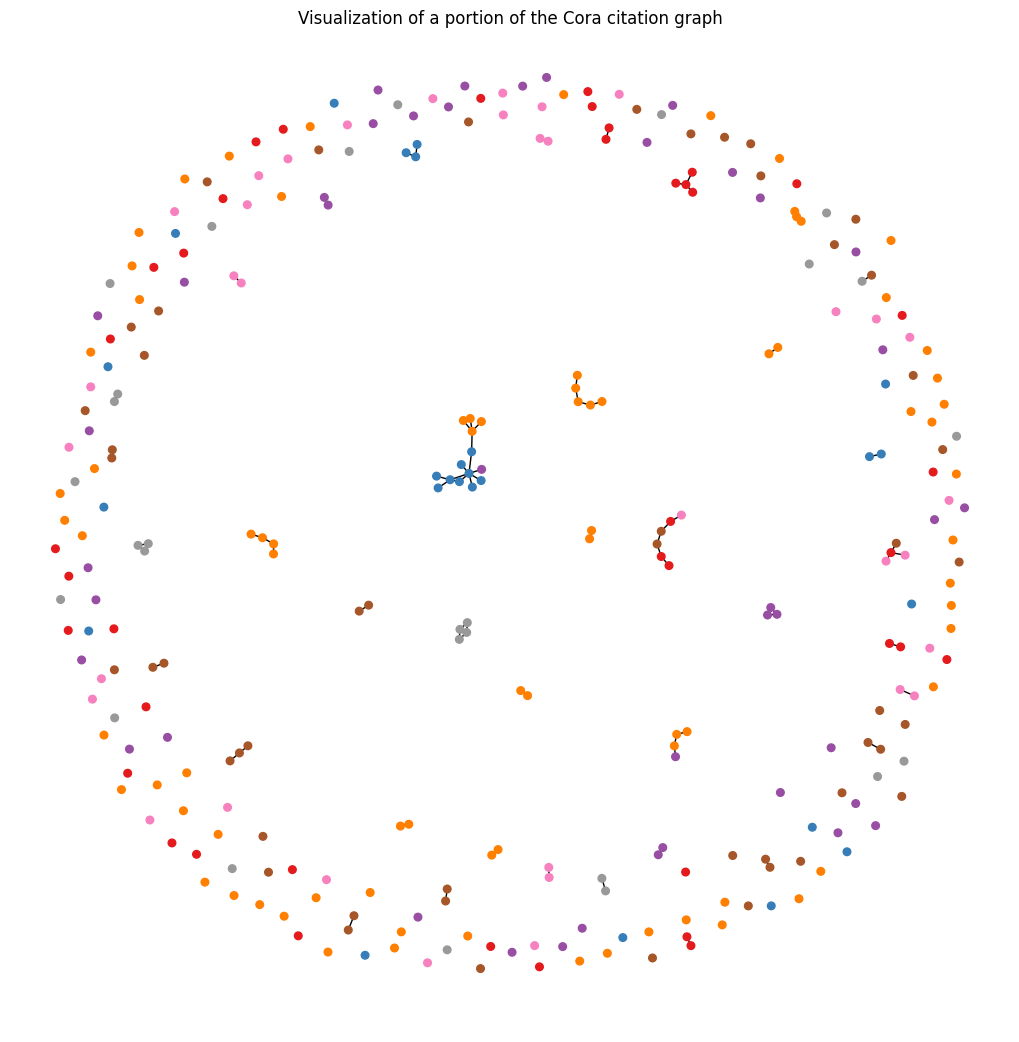

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(10, 10))
nx.draw(G.subgraph(list(G.nodes)[:300]), node_size=30, node_color=data.y[:300], cmap='Set1')
plt.title("Visualization of a portion of the Cora citation graph")
plt.show()


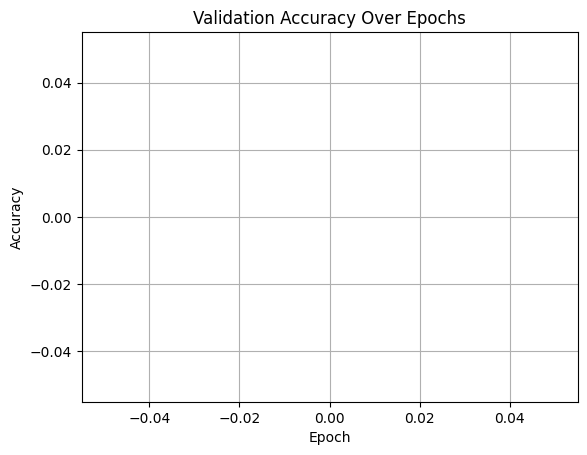

In [12]:
val_accs = []
plt.plot(val_accs)
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
